# Upstage Full Stack LLM with Langchain
## Code to Understand!
![Overview](./figures/overview.png)

In [1]:
! pip3 install -qU guardrails-ai openai langchain_community langchain_experimental langchain-upstage sentence-transformers langchainhub langchain-chroma langchain matplotlib python-dotenv tavily-python ragas faiss-cpu tokenizers 

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Set .env and define these:
# UPSTAGE_API_KEY from https://console.upstage.ai/
# TAVILY_API_KEY https://app.tavily.com
# NEWS_API_KEY from https://newsapi.org/

%load_ext dotenv
%dotenv


## Interacting with the Solar-1-mini-chat Model

This Python code demonstrates how to use the OpenAI API to interact with the Solar-1-mini-chat model provided by Upstage AI.

### Steps

1. Import necessary libraries: `os`, `openai`, and `pprint`.
2. Set up the OpenAI client with the API key and base URL.
3. Create a chat completion request using `client.chat.completions.create()`.
   - Specify the model: "solar-1-mini-chat".
   - Provide a list of messages, including the system message and user message.
4. Handle the model's response:
   - Print the entire response using `pprint()`.
   - Print the content of the assistant's message using `response.choices[0].message.content`.

In [4]:
import os
from openai import OpenAI
from pprint import pprint

client = OpenAI(
    api_key=os.environ["UPSTAGE_API_KEY"], base_url="https://api.upstage.ai/v1/solar"
)
chat_result = client.chat.completions.create(
    model="solar-1-mini-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "What about Korea?"},
    ],
)
pprint(chat_result)
print("Message only:")
pprint(chat_result.choices[0].message.content)

ChatCompletion(id='0355a0b1-b0a3-4fb3-8889-26e8f520ee7c', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Korea is a country located in East Asia. It is bordered by China to the northwest and Russia to the northeast. The Korean Peninsula is separated from Japan by the Sea of Japan and the East China Sea. The capital city is Seoul, which is also the largest city in South Korea. The official language is Korean, and the currency is the South Korean won. Korea is known for its rich history, beautiful landscapes, and modern technology.', role='assistant', function_call=None, tool_calls=None))], created=1715139294, model='solar-1-mini-chat-240502', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=96, prompt_tokens=26, total_tokens=122))
Message only:
('Korea is a country located in East Asia. It is bordered by China to the '
 'northwest and Russia to the northeast. The Korean Peninsula is separated

## Using Few-Shot Examples in Chat Completions

This Python code demonstrates how to use few-shot examples in the OpenAI Chat Completions API to provide context and guide the model's responses.

### Steps

1. Set up the OpenAI client with the API key and base URL.
2. Create a chat completion request using `client.chat.completions.create()`.
   - Specify the model: "solar-1-mini-chat".
   - Provide a list of messages, including:
     - System message: Defines the assistant's role.
     - Few-shot examples: Provide context and desired behavior.
     - User input: The actual user query.
3. Handle the model's response:
   - Print the entire response using `pprint()`.
   - Print the content of the assistant's message using `response.choices[0].message.content`.

In [5]:
# few shots: examples or history
chat_result = client.chat.completions.create(
    model="solar-1-mini-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        # examples
        {"role": "user", "content": "What is the capital of France?"},
        {
            "role": "assistant",
            "content": "I know of it. It's Paris!!",
        },
        # user input
        {"role": "user", "content": "What about Korea?"},
    ],
)
pprint(chat_result)
print("Message only:")
pprint(chat_result.choices[0].message.content)

ChatCompletion(id='aba1c6dd-a922-4ff7-b28a-5564e04495b7', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Oh, that's a good one. I think it's Seoul!!", role='assistant', function_call=None, tool_calls=None))], created=1715139295, model='solar-1-mini-chat-240502', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=21, prompt_tokens=55, total_tokens=76))
Message only:
"Oh, that's a good one. I think it's Seoul!!"


## Building LLM Applications with LangChain

This Python code demonstrates how to use the LangChain library to build applications with Large Language Models (LLMs). It covers the basic steps of defining an LLM, creating a chat prompt, defining a chain, and invoking the chain.

### Steps

1. Define your favorite LLM:
   - Import the `ChatUpstage` class from `langchain_upstage`.
   - Create an instance of `ChatUpstage` and assign it to the variable `llm`.

2. Define a chat prompt:
   - Import the `ChatPromptTemplate` class from `langchain_core.prompts`.
   - Create a `ChatPromptTemplate` instance using the `from_messages()` method.
   - Provide a list of messages, including system messages, example conversations, and user input.

3. Define a chain:
   - Import the `StrOutputParser` class from `langchain_core.output_parsers`.
   - Create a chain by combining the `rag_with_history_prompt`, `llm`, and `StrOutputParser()` using the pipe (`|`) operator.

4. Invoke the chain:
   - Call the `invoke()` method on the `chain` object, passing an empty dictionary (`{}`) as the input.
   - Print the response obtained from the chain.

In [6]:
# Quick hello world
from langchain_upstage import ChatUpstage

llm = ChatUpstage()
llm.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm an artificial intelligence and don't have feelings or emotions, but I'm here to help you with any questions or problems you may have. How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 16, 'total_tokens': 61}, 'model_name': 'solar-1-mini-chat', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b4e11d0e-d524-4175-acb8-8f1c2da2c45e-0')

In [7]:
# langchain, 1. llm define, 2. prompt define, 3. chain, 4. chain.invoke

# 1. define your favorate llm, solar
from langchain_upstage import ChatUpstage

llm = ChatUpstage()

# 2. define chat prompt
from langchain_core.prompts import ChatPromptTemplate

rag_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human", "What is the capital of France?"),
        ("ai", "I know of it. It's Paris!!"),
        ("human", "What about Korea?"),
    ]
)

# 3. define chain
from langchain_core.output_parsers import StrOutputParser

chain = rag_with_history_prompt | llm | StrOutputParser()

# 4. invoke the chain
c_result = chain.invoke({})
print(c_result)

Oh, I know that too! It's Seoul!!


## Parameterized Prompt Templates in LangChain

### Overview

- Prompt templates allow for reusable and modular prompts
- They improve maintainability compared to using raw prompt strings
- {country} value can be set from outside

In [8]:
# parameterized prompt template
rag_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human", "What is the capital of France?"),
        ("ai", "I know of it. It's Paris!!"),
        ("human", "What about {country}?"),
    ]
)

chain = rag_with_history_prompt | llm | StrOutputParser()

# 4. invoke chain with param
print(chain.invoke({"country": "Korea"}))
print("---")
print(chain.invoke({"country": "Japan"}))

Ohhh... I don't know that one. I'm not good at remembering all the capitals of countries. But I'm sure I can learn it if you tell me!
---
Tokyo, it's the place they call home!!


## Leveraging Message History in LangChain Prompts

- LangChain provides powerful tools for managing conversation history
- `MessagesPlaceholder` allows for dynamic inclusion of message history
- `HumanMessage` and `AIMessage` classes represent individual messages
- Combining message history with user input enables context-aware responses

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# More general chat
rag_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

from langchain_core.messages import AIMessage, HumanMessage

history = [
    HumanMessage("What is the capital of France?"),
    AIMessage("It's Paris!!"),
]

chain = rag_with_history_prompt | llm | StrOutputParser()
chain_result = chain.invoke({"history": history, "input": "What about Korea?"})
print(chain_result)

Oh, that's easy! It's Seoul!!


![Hallucination](./figures/hallucination.png)

In [10]:
# Cannot say "I don't know" :-)
# Because it is trained to complete the sentence and try to answer the question
llm.invoke("What is Upstage DUS technique?")

AIMessage(content='The Upstage DUS technique is a method used in the field of ultrasound imaging, specifically in the assessment of the ductus arteriosus (DUS) in newborns. The ductus arteriosus is a fetal blood vessel that typically closes shortly after birth, but in some cases, it may remain open, leading to various complications.\n\nThe Upstage DUS technique involves performing an ultrasound examination of the ductus arteriosus with the patient in a specific position, known as the "upstage" position. This position involves placing the patient in a prone (face-down) position with the head turned to one side and the hips and knees flexed. This position helps to optimize the visualization of the ductus arteriosus and improves the accuracy of the examination.\n\nDuring the Upstage DUS technique, an ultrasound probe is placed on the patient\'s chest to visualize the ductus arteriosus and assess its patency (openness). The examination typically includes measuring the size and flow velocit

## RAG
Provide context and allow the language model to respond within that context only.
![Overview](./figures/rag.png)

# Leveraging Layout Analyzer and LangChain for Efficient Text Splitting and Vectorization

- Upstage Layout Analyzer extracts layouts, tables, and figures from any document
- LangChain provides powerful tools for text splitting and vectorization
![Layout Analyzer](./figures/la.png)

In [11]:
from langchain_upstage import (
    UpstageLayoutAnalysisLoader,
    UpstageGroundednessCheck,
    ChatUpstage,
    UpstageEmbeddings,
)
from langchain_chroma import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter


layzer = UpstageLayoutAnalysisLoader("./solar_paper.pdf", output_type="html")
# For improved memory efficiency, consider using the lazy_load method to load documents page by page.
docs = layzer.load()  # or layzer.lazy_load()

In [12]:
for doc in docs:
    pprint(doc.page_content[:100])

("<table id='0' "
 "style='font-size:14px'><tr><td>Model</td><td>Size</td><td>Type</td><td>H6 "
 '(Avg.)</td><')


## Retrieval Augmented Generation (RAG) for Question Answering

- RAG combines retrieval and generation to enhance LLM performance on specific tasks
- Relevant context is retrieved from external data sources and added to the prompt
- The augmented prompt is then passed to the LLM for generating a response
- RAG is particularly useful for question answering on custom datasets

In [13]:
# More general chat
rag_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question considering the history of the conversation. 
If you don't know the answer, just say that you don't know. 
---
CONTEXT:
{context}
         """,
        ),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

from langchain_core.messages import AIMessage, HumanMessage

history = []

chain = rag_with_history_prompt | llm | StrOutputParser()
query1 = "Performance comparison amongst the merge candidate"
response1 = chain.invoke({"history": history, "context": docs, "input": query1})
print("RESPONSE1\n", response1)

RESPONSE1
 To provide a performance comparison amongst the merge candidates, I will use the information from Table 6 in the provided context.

Table 6 compares two merge candidates, 'Cand. 1' and 'Cand. 2', which were trained using the same training dataset and SFT base model as 'DPO v2' and 'DPO v3' respectively but with different hyper-parameters to maximize each model's respective strengths.

Here is the comparison:

| Model | H6 (Avg.) | ARC | HellaSwag | MMLU | TruthfulQA | Winogrande | GSM8K |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Cand. 1 | 73.73 | 70.48 | 87.47 | 65.73 | 70.62 | 81.53 | 66.57 |
| Cand. 2 | 73.28 | 71.59 | 88.39 | 66.14 | 72.50 | 81.99 | 59.14 |

From the table, we can see that 'Cand. 1' has high GSM8K scores but relatively low scores for the other tasks, whereas 'Cand. 2' has low scores for GSM8K but high scores for the other tasks. This indicates that 'Cand. 1' is stronger in GSM8K and 'Cand. 2' is stronger in the other tasks.


In [14]:
history = [HumanMessage(query1), AIMessage(response1)]
query2 = "How about Ablation studies?"
response2 = chain.invoke({"history": history, "context": docs, "input": query2})
print("RESPONSE2\n", response2)

RESPONSE2
 To provide an overview of the ablation studies mentioned in the context, I will summarize the different ablation studies conducted on the instruction and alignment tuning stages.

1. Ablation on the training datasets for instruction tuning:

   - SFT v1: Only uses the Alpaca-GPT4 dataset.
   - SFT v2: Adds the OpenOrca dataset to SFT v1.
   - SFT v3: Adds the Synth. Math-Instruct dataset to SFT v2.
   - SFT v4: Adds the Synth. Math-Instruct dataset to SFT v1.
   - SFT v3 + v4: Merges SFT v3 and SFT v4 by averaging model weights.

   The results show that adding the Synth. Math-Instruct dataset is beneficial and that merging models with different strengths can boost performance.

2. Ablation on the SFT base models for alignment tuning:

   - DPO v1: Uses 'SFT v3' as the SFT base model and only uses the Ultrafeedback Clean dataset.
   - DPO v2: Uses 'SFT v3' as the SFT base model and adds the Synth. Math-Alignment dataset.
   - DPO v3: Uses 'SFT v3 + v4' as the SFT base model.

In [15]:
# Let's load something big
layzer = UpstageLayoutAnalysisLoader("./kim-tse-2008.pdf", output_type="html")
# For improved memory efficiency, consider using the lazy_load method to load documents page by page.
docs = layzer.load()  # or layzer.lazy_load()

###  RAG Limitations
- LLM does not have long enough context length
- Sending long, irrelevant info is inefficient

In [16]:
chain = rag_with_history_prompt | llm | StrOutputParser()
query1 = "What is bug classification?"

try:
    response1 = chain.invoke({"history": history, "context": docs, "input": query1})
    print(response1)
except Exception as e:
    print(e)

Error code: 400 - {'error': {'message': "This model's maximum context length is 32768 tokens. However, your messages resulted in 35880 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


In [17]:
print(len(docs[0].page_content))

104448


In [18]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_pretrained("upstage/solar-1-mini-tokenizer")

In [19]:
text = "Nice to meet you. I am Solar LLM, a large language model developed by Upstage. If you have any questions, please feel free to ask."

enc = tokenizer.encode(text)
print("Encoded input:", enc.tokens)

number_of_tokens = len(enc.tokens)
print("Number of tokens:", number_of_tokens)

Encoded input: ['<|startoftext|>', '▁Nice', '▁to', '▁meet', '▁you', '.', '▁I', '▁am', '▁Solar', '▁LL', 'M', ',', '▁a', '▁large', '▁language', '▁model', '▁developed', '▁by', '▁Up', 'stage', '.', '▁If', '▁you', '▁have', '▁any', '▁questions', ',', '▁please', '▁feel', '▁free', '▁to', '▁ask', '.']
Number of tokens: 33


In [20]:
text = "만나서 반가워요. 저는 Upstage에서 개발한 대규모 언어 모델인 Solar LLM 입니다. 궁금한 것이 있으시면 무엇이든 물어보세요."
enc = tokenizer.encode(text)
print("Encoded input:", enc.tokens)

number_of_tokens = len(enc.tokens)
print("Number of tokens:", number_of_tokens)

Encoded input: ['<|startoftext|>', '▁만나', '서', '▁반가', '워', '요', '.', '▁저는', '▁Up', 'stage', '에서', '▁개발한', '▁대규모', '▁언어', '▁모델', '인', '▁Solar', '▁LL', 'M', '▁입니다', '.', '▁궁금한', '▁것이', '▁있으', '시면', '▁무엇이', '든', '▁물어', '보세요', '.']
Number of tokens: 30


In [21]:
enc = tokenizer.encode(text)
print("Encoded input:", enc.tokens)

number_of_tokens = len(enc.tokens)
print("Number of tokens:", number_of_tokens)

Encoded input: ['<|startoftext|>', '▁만나', '서', '▁반가', '워', '요', '.', '▁저는', '▁Up', 'stage', '에서', '▁개발한', '▁대규모', '▁언어', '▁모델', '인', '▁Solar', '▁LL', 'M', '▁입니다', '.', '▁궁금한', '▁것이', '▁있으', '시면', '▁무엇이', '든', '▁물어', '보세요', '.']
Number of tokens: 30


In [22]:
def num_of_tokens(text):
    return len(tokenizer.encode(text).tokens)

In [23]:
print(
    "ENG",
    num_of_tokens(
        "Nice to meet you. I am Solar LLM, a large language model developed by Upstage. If you have any questions, please feel free to ask."
    ),
)
print(
    "KOR",
    num_of_tokens(
        "만나서 반가워요. 저는 Upstage에서 개발한 대규모 언어 모델인 Solar LLM 입니다. 궁금한 것이 있으시면 무엇이든 물어보세요."
    ),
)

ENG 33
KOR 30


In [24]:
# Recall
# Let's load something big
# layzer = UpstageLayoutAnalysisLoader("./kim-tse-2008.pdf", output_type="html")
# For improved memory efficiency, consider using the lazy_load method to load documents page by page.
# docs = layzer.load()  # or layzer.lazy_load()
print("String length", len(docs[0].page_content))
print("Number of tokens", num_of_tokens(docs[0].page_content))

String length 104448
Number of tokens 34553


## Efficient Text Splitting and Indexing with LangChain

### 1. Load Documents

The first step is to load the source documents that will be used to augment the language model's knowledge
This could be done by reading files from disk, pulling from a database, scraping web pages, etc.
The goal is to get the raw text content into a format that can be further processed

### 2. Chunking/Splitting

* Long documents need to be broken down into smaller chunks that are a manageable size for embedding and retrieval
Common approaches include:
  * Fixed-size chunking - split text into equal sized chunks based on character or token count 
  * Semantic chunking - split based on semantic boundaries like sentences, paragraphs, or sections
  * Hierarchical chunking - create chunks at multiple levels of granularity
The ideal chunk size depends on the embedding model, retrieval use case, and downstream task

### 3. Embedding & Indexing

* The text chunks are converted to vector embeddings using a model like Upstage embeddings
* The embeddings are indexed and stored in a vector database to enable efficient similarity search 
* Metadata about the source chunks can also be stored alongside the embeddings

### 4. Retrieval

* At query time, the user's question is itself embedded as a query vector
* The query embedding is used to find the most similar document chunks in the vector index 
* Top-k most relevant chunks are retrieved and can be used to augment the prompt sent to the language model to generate an answer

In [25]:
# RAG 1. load doc (done), 2. chunking, splits, 3. embeding - indexing, 4. retrieve

# 2. Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
splits = text_splitter.split_documents(docs)
print("Splits:", len(splits))

Splits: 124


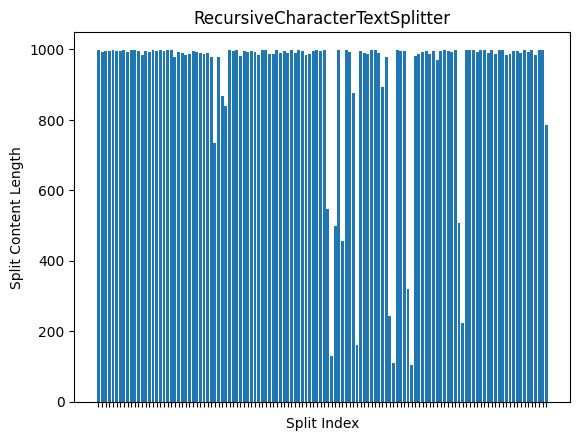

In [26]:
import matplotlib.pyplot as plt

split_lengths = [len(split.page_content) for split in splits]

# Create a bar graph
plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

In [27]:
%%time
# 3. Embed & indexing
vectorstore = Chroma.from_documents(documents=splits, embedding=UpstageEmbeddings())

CPU times: user 3.54 s, sys: 110 ms, total: 3.65 s
Wall time: 1min 41s


In [28]:
# 4. retrive
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
result_docs = retriever.invoke("What is Bug Classification?")
print(len(result_docs))
print(result_docs[0].page_content[:100])

3
data to train a classifica-<br>tion model. As discussed in Section 8.3, the change</p><header id='56


![Overview](./figures/semantic_chunker.png)

In [29]:
# 2-2. SemanticChunker Split
from langchain_community.utils.math import cosine_similarity
from langchain.docstore.document import Document


def semantic_chunker(
    docs,
    min_chunk_size=100,
    chunk_overlap=10,
    max_chunk_size=1000,
    merge_threshold=0.7,
    embeddings=UpstageEmbeddings(),
):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=min_chunk_size, chunk_overlap=chunk_overlap
    )
    init_splits = text_splitter.split_documents(docs)
    splits = []

    base_split_text = None
    base_split_emb = None
    for split in init_splits:
        if base_split_text is None:
            base_split_text = split.page_content
            base_split_emb = embeddings.embed_query(base_split_text)
            continue

        split_emb = embeddings.embed_query(split.page_content)
        distance = cosine_similarity(X=[base_split_emb], Y=[split_emb])
        if (
            distance[0][0] < merge_threshold
            or len(base_split_text) + len(split.page_content) > max_chunk_size
        ):
            splits.append(Document(page_content=base_split_text))
            base_split_text = split.page_content
            base_split_emb = split_emb
        else:
            base_split_text += split.page_content

    if base_split_text:
        splits.append(Document(page_content=base_split_text))

    return splits

## HuggingFaceEmbeddings
Since it's just an approximation, it's acceptable to use very light embedding models like KLUE, https://huggingface.co/klue.

In [30]:
%%time
from langchain_community.embeddings import HuggingFaceEmbeddings
hfembeddings = HuggingFaceEmbeddings(model_name="klue/roberta-small")

No sentence-transformers model found with name klue/roberta-small. Creating a new one with MEAN pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 2.74 s, sys: 5.53 s, total: 8.27 s
Wall time: 5.29 s


In [31]:
%%time
semantic_splits = semantic_chunker(docs,  merge_threshold=0.8, embeddings=hfembeddings)
print("SemanticChunker Splits:", len(semantic_splits))

SemanticChunker Splits: 250
CPU times: user 19.1 s, sys: 1.82 s, total: 20.9 s
Wall time: 20.8 s


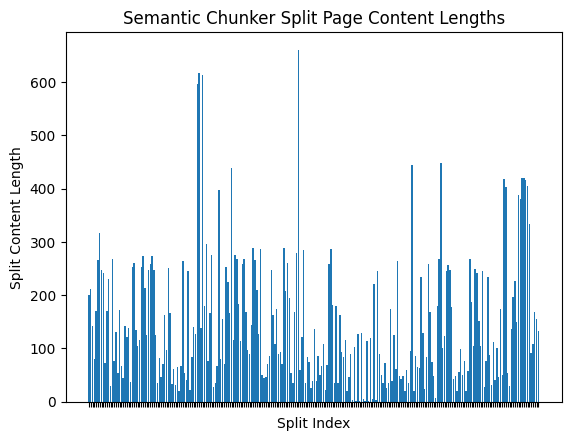

In [32]:
import matplotlib.pyplot as plt

split_lengths = [num_of_tokens(split.page_content) for split in semantic_splits]

# Create a bar graph
plt.bar(range(len(split_lengths)), split_lengths)
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.title("Semantic Chunker Split Page Content Lengths")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## ChromaParallel Class: Parallel Document Embedding
The ChromaParallel class is an extension of the Chroma class to enable parallel processing of document embedding and storage using multiple worker processes.

In [33]:
import asyncio


class ChromaParallel(Chroma):

    async def afrom_documents(documents, embedding, num_workers=2):
        db = Chroma(embedding_function=embedding)
        # create list of num_workers empty lists
        doc_groups = [[] for _ in range(num_workers)]

        for i in range(len(documents)):
            doc_groups[i % num_workers].append(documents[i])

        tasks = [db.aadd_documents(group) for group in doc_groups]
        await asyncio.gather(*tasks)
        return db

In [34]:
import asyncio
import time

now = time.time()
# 3. Embed & indexing
loop = asyncio.get_event_loop()
semantic_vectorstore = await ChromaParallel.afrom_documents(
    documents=semantic_splits, embedding=UpstageEmbeddings(), num_workers=10
)
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k": 3})

# 4. retrive
result_docs = semantic_retriever.invoke("What is Bug Classification?")
print(result_docs[1])
print(f"Wall time: {time.time() - now:.2f} sec")

page_content='id=\'2\' style=\'font-size:22px\'>TABLE 6<br>Correlation between the Percentage of Buggy Changes andand Percentage of Change Classification Performance</caption></table><table id=\'5\'id=\'5\' style=\'font-size:16px\'><tr><td rowspan="2">Feature Group</td><td colspan="12">Number of'
Wall time: 32.56 sec


In [35]:
# Finally query using RAG
query = "What is bug classification? How it works?"
result_docs = semantic_retriever.invoke(query)

gc_result = chain.invoke({"history": history, "context": result_docs, "input": query})
print(gc_result)

Bug classification is a process in software engineering where software bugs or issues are categorized based on their characteristics, severity, or other relevant factors. The goal of bug classification is to organize and prioritize bugs in a way that helps developers identify and fix the most critical issues first.

Here's how bug classification works:

1. **Data Collection**: The first step in bug classification is to collect data on bugs or issues found in the software. This data can include information such as the bug description, the environment in which the bug was found, the steps to reproduce the bug, and other relevant details.

2. **Feature Extraction**: From the collected data, relevant features are extracted. These features can include keywords, phrases, or other characteristics that describe the bug. For example, the feature extraction process might identify the components of the software that are affected by the bug, the type of error message generated, or the impact of th

In [36]:
history = [HumanMessage(query), AIMessage(gc_result)]

query = "Why it is good?"
result_docs = semantic_retriever.invoke(query)

gc_result = chain.invoke({"history": history, "context": result_docs, "input": query})
print(gc_result)

Bug classification is beneficial for several reasons:

1. **Efficient Bug Management**: By categorizing bugs, development teams can manage and prioritize their bug fixes more effectively. This allows them to focus on the most critical issues first, ensuring that the software remains stable and reliable.

2. **Improved Productivity**: With a well-defined bug classification system, developers can quickly identify the nature of a bug and the components of the software it affects. This reduces the time spent on investigating and diagnosing bugs, leading to increased productivity.

3. **Better Quality Assurance**: Bug classification helps in identifying patterns and trends in the bugs reported. This information can be used to improve the quality assurance process, such as by focusing more testing efforts on areas prone to certain types of bugs.

4. **Enhanced Customer Satisfaction**: By prioritizing and fixing the most critical bugs first, development teams can ensure that the software prov

## RAG Evaluation using Ragas
RAGAS is a framework that helps evaluate Retrieval Augmented Generation (RAG) pipelines. We generate questions from context and retrieve from a vector database. Then, we measure retrieval precision and recall.

We use solar llm to create questions and to judge them as well.

In [62]:
# https://github.com/explodinggradients/ragas/blob/main/src/ragas/testset/prompts.py
from ragas.testset.prompts import keyphrase_extraction_prompt, seed_question_prompt
from langchain_core.prompts import PromptTemplate


def generate_questions(docs, n=10):
    questions = []
    chain = llm | StrOutputParser()

    # Extract keyphrases
    context = docs[0].page_content[:10000]
    ragas_prompt = keyphrase_extraction_prompt.format(text=context)
    keyphrase_extraction_results = chain.invoke(ragas_prompt.prompt_str)
    pprint(keyphrase_extraction_results)

    for _ in range(n):
        ragas_prompt = seed_question_prompt.format(
            keyphrase=keyphrase_extraction_results, context=context
        )
        questions_results = chain.invoke(ragas_prompt.prompt_str)
        questions.append(questions_results)
    return questions


questions = generate_questions(docs)
pprint(questions)

('{\n'
 '  "keyphrases": [\n'
 '    "Software Changes",\n'
 '    "Classification",\n'
 '    "Machine Learning",\n'
 '    "Bug Prediction",\n'
 '    "Software Configuration Management"\n'
 '  ]\n'
 '}')
['How does the change classification technique for predicting latent software '
 'bugs work, and what are the key steps involved in this process?',
 'How does the change classification technique work in predicting latent '
 'software bugs in file-level software changes, and what are the main '
 'contributions of this paper in terms of bug prediction and feature '
 'extraction?',
 'What is the change classification technique used in the paper, and how is it '
 'different from traditional bug-finding techniques?',
 'How does the change classification technique work in predicting latent '
 'software bugs in file-level software changes?',
 'What is the main objective of the change classification technique introduced '
 'in the paper, and how does it aim to help developers in the software '
 

In [38]:
from langchain_community.vectorstores import FAISS

print("split_lengths", len(splits))
print("semantic_split_lengths", len(semantic_splits))

# 124 VS 250

size_vectorstore = FAISS.from_documents(documents=splits, embedding=UpstageEmbeddings())
size_split_retriever = size_vectorstore.as_retriever(search_kwargs={"k": 3})

semantic_vectorstore = await ChromaParallel.afrom_documents(
    documents=semantic_splits, embedding=UpstageEmbeddings(), num_workers=10
)

semantic_split_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k": 6})

split_lengths 124
semantic_split_lengths 250


In [39]:
from ragas.testset.evolutions import DataRow
from ragas.testset.generator import TestsetGenerator, TestDataset
from tqdm.notebook import tqdm
from datasets import Dataset

size_split_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": [],
}
semantic_split_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": [],
}


def fill_data(data, question, retr):
    results = retr.invoke(question)
    context = [doc.page_content for doc in results]

    # chain = rag_with_history_prompt | llm | StrOutputParser()
    # answer = chain.invoke({"history": [], "context": context, "input": question})

    data["question"].append(question)
    data["answer"].append("")
    data["contexts"].append(context)
    data["ground_truth"].append("")


for question in questions:
    fill_data(size_split_data, question, size_split_retriever)
    fill_data(semantic_split_data, question, semantic_split_retriever)


size_split_dataset = Dataset.from_dict(size_split_data)
semantic_split_dataset = Dataset.from_dict(semantic_split_data)

In [40]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from ragas import evaluate


def ragas_evalate(dataset):
    result = evaluate(
        dataset,
        metrics=[
            context_precision,
            context_recall,
            # answer_relevancy,
            # faithfulness,
        ],
        llm=llm,
        embeddings=UpstageEmbeddings(),
    )
    return result

In [41]:
print("Size splits", ragas_evalate(size_split_dataset))
print("Semantic splits", ragas_evalate(semantic_split_dataset))

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Size splits {'context_precision': 0.8889, 'context_recall': 1.0000}


Evaluating: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]

Semantic splits {'context_precision': 0.9472, 'context_recall': 1.0000}


## Explanation of the Code: Query Expander

The provided code demonstrates a query expansion technique used in Retrieval Augmented Generation (RAG) systems. The main goal is to generate multiple variations of a given user query to retrieve relevant documents from a vector database more effectively. By generating different perspectives on the user query, the system aims to overcome some limitations of distance-based similarity search.

The code defines a function called `query_expander` that takes a user query as input and returns a list of expanded queries. It uses three different query expansion templates:

1. Multi Query: Generates five different versions of the user query to retrieve relevant documents from different perspectives.
2. RAG-Fusion: Generates four related search queries based on the input query.
3. Decomposition: Breaks down the input query into three sub-questions that can be answered in isolation.

The expanded queries are generated using the LangChain library, specifically the `ChatUpstage` model, and the results are parsed using the `StrOutputParser`.

In [42]:
from langchain_upstage import ChatUpstage
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate


def query_expander(query):
    # Multi Query: Different Perspectives
    multi_query_template = """You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines. Original question: {query}"""

    # RAG-Fusion: Related
    rag_fusion_template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
    Generate multiple search queries related to: {query} \n
    Output (4 queries):"""

    # Decomposition
    decomposition_template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
    The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
    Generate multiple search queries related to: {query} \n
    Output (3 queries):"""

    query_expander_templates = [
        multi_query_template,
        rag_fusion_template,
        decomposition_template,
    ]

    expanded_queries = []
    for template in query_expander_templates:
        prompt_perspectives = ChatPromptTemplate.from_template(template)

        generate_queries = (
            prompt_perspectives
            | ChatUpstage(temperature=0)
            | StrOutputParser()
            | (lambda x: x.split("\n"))
        )
        expanded_queries += generate_queries.invoke({"query": query})

    return expanded_queries


expanded_queries = query_expander("What is the DUS approach developed by Upstage?")
pprint(expanded_queries)

['1. Can you explain the DUS methodology created by Upstage?',
 '2. What is the DUS approach developed by Upstage and how does it work?',
 '3. Can you provide an overview of the DUS technique developed by Upstage?',
 '4. How does the DUS approach developed by Upstage differ from other similar '
 'methods?',
 '5. What are the key features of the DUS methodology developed by Upstage?',
 '1. "DUS approach by Upstage: definition and explanation"',
 '2. "How does the DUS approach by Upstage differ from other methods?"',
 '3. "Real-world applications of the DUS approach developed by Upstage"',
 '4. "Case studies showcasing the effectiveness of the DUS approach by '
 'Upstage"',
 '1. What is the DUS approach developed by Upstage?',
 '2. How does the DUS approach developed by Upstage work?',
 '3. What are the key features of the DUS approach developed by Upstage?']


In [43]:
# Finally query using RAG
oroginal_query = "What is bug classification? Why it is good?"
expanded_queries = query_expander(oroginal_query)
expanded_queries.append(oroginal_query)

expended_result_docs = []
for query in expanded_queries:
    print("Search for: ", query)
    result_docs = retriever.invoke(query)
    expended_result_docs.append(result_docs)

# remove duplicates
unique_docs = list(set(expanded_queries))
print("expended_result_docs", len(expended_result_docs))
print("Unique docs:", len(unique_docs))

gc_result = chain.invoke(
    {"history": history, "context": expanded_queries, "input": query}
)
print(gc_result)

Search for:  1. What is the process of categorizing bugs in software development?
Search for:  2. How does bug classification benefit software development?
Search for:  3. What are the different types of bugs and how are they classified?
Search for:  4. What are the advantages of bug classification in software development?
Search for:  5. How does bug classification help in identifying and fixing software issues?
Search for:  1. "Bug classification techniques"
Search for:  2. "Importance of bug classification in software development"
Search for:  3. "Bug classification tools and methodologies"
Search for:  4. "Benefits of effective bug classification for software quality assurance"
Search for:  1. What is the definition of bug classification in software development?
Search for:  2. What are the benefits of bug classification for software development teams?
Search for:  3. How does bug classification contribute to efficient and effective software development processes?
Search for:  What

## Explanation of the Code: Smart Retrieval Augmented Generation (RAG)

### High-Level Overview

The code demonstrates a smart Retrieval Augmented Generation (RAG) system that combines local retrieval with external search capabilities. The main goal is to provide relevant context for answering user questions by first searching a local vector database and then falling back to an external search service if the local context is insufficient.


The code defines two main functions:


  1. is_in: Determines whether the answer to a given question can be found within the provided context.
smart_rag: Retrieves relevant context for a given question, either from the local vector database or an external search service, and generates an answer using the retrieved context.

  1. The code uses the LangChain library for generating prompts and invoking language models, as well as the Tavily API for external search capabilities.


### Detailed Explanation 

1. The code starts by defining the is_in function, which takes a question and context as input and determines whether the answer to the question can be found within the context.
    * It defines a prompt template called is_in_conetxt that asks the language model to check if the answer is in the context and return "yes" or "no".
    * The prompt template is used to create a ChatPromptTemplate object.
    * A chain of operations is constructed using the | operator:
      * The ChatPromptTemplate is passed to the ChatUpstage model.
      * The model's output is parsed using the StrOutputParser.
    * The chain is invoked with the question and context, and the response is stored in the response variable.
    * The function returns True if the response starts with "yes" (case-insensitive), indicating that the answer is in the context.

1. The code then demonstrates the usage of the is_in function with two example questions and their corresponding contexts retrieved from a retriever.

1. Next, the code defines the smart_rag function, which takes a question as input and generates an answer using the retrieved context.
    * It first retrieves the context for the question using the retriever.invoke method.
    * If the is_in function determines that the answer is not in the retrieved context, it falls back to searching for additional context using the Tavily API.
    * The retrieved context (either from the local retriever or Tavily) is stored in the context variable.
    * A chain of operations is constructed using the | operator:
      * The rag_with_history_prompt (not shown in the code snippet) is used as the prompt template.
      * The prompt is passed to the llm language model.
      * The model's output is parsed using the StrOutputParser.
    * The chain is invoked with the conversation history, retrieved context, and the question, and the generated answer is returned.

1. Finally, the code demonstrates the usage of the smart_rag function with two example questions:
    * "What is DUS?": The answer is expected to be found in the local context.
    * "What's the population of San Francisco?": The answer is not expected to be found in the local context, so it falls back to searching with Tavily.

This code showcases how LangChain can be used to build a smart RAG system that combines local retrieval with external search capabilities. By first searching a local vector database and falling back to an external search service if needed, the system aims to provide relevant context for generating accurate answers to user questions.

In [44]:
# RAG or Search?
def is_in(question, context):
    is_in_conetxt = """As a helpful assistant, 
please use your best judgment to determine if the answer to the question is within the given context. 
If the answer is present in the context, please respond with "yes". 
If not, please respond with "no". 
Only provide "yes" or "no" and avoid including any additional information. 
Please do your best. Here is the question and the context.:
---
CONTEXT: {context}
---
QUESTION: {question}
---
OUTPUT (yes or no):"""

    is_in_prompt = ChatPromptTemplate.from_template(is_in_conetxt)
    chain = is_in_prompt | ChatUpstage() | StrOutputParser()

    response = chain.invoke({"history": [], "context": context, "question": question})
    print(response)
    return response.lower().startswith("yes")

In [45]:
question = "Can you tell me about Yi Sun-sin, a Korean admiral?"
context = semantic_split_retriever.invoke(question)
print(is_in(question, context))

no
False


In [46]:
question = "bug classification?"
context = semantic_split_retriever.invoke(question)
print(is_in(question, context))

yes
True


In [47]:
# Smart RAG, Self-Improving RAG
from tavily import TavilyClient


def smart_rag(question):
    context = retriever.invoke(question)
    if not is_in(question, context):
        print("Searching in tavily")
        tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
        context = tavily.search(query=question)

    chain = rag_with_history_prompt | llm | StrOutputParser()
    return chain.invoke({"history": history, "context": context, "input": question})

In [48]:
question = "bug classification?"
smart_rag(question)

yes


'Bug classification is a process in software engineering where software bugs or issues are categorized based on their characteristics, severity, or other relevant factors. The goal of bug classification is to organize and prioritize bugs in a way that helps developers identify and fix the most critical issues first.\n\nHere\'s how bug classification works:\n\n1. **Data Collection**: The first step in bug classification is to collect data on bugs or issues found in the software. This data can include information such as the bug description, the environment in which the bug was found, the steps to reproduce the bug, and other relevant details.\n\n2. **Feature Extraction**: From the collected data, relevant features are extracted. These features can include keywords, phrases, or other characteristics that describe the bug. For example, the feature extraction process might identify the components of the software that are affected by the bug, the type of error message generated, or the impa

In [49]:
question = "Can you tell me about Yi Sun-sin, a Korean admiral?"
smart_rag(question)

no
Searching in tavily


'Yi Sun-sin was a Korean admiral who lived during the 16th century. He is considered one of the greatest naval commanders in history and is revered in both North and South Korea. Yi Sun-sin played a crucial role in defending Korea against Japanese invasions during the Imjin Wars (1592-1598).\n\nYi Sun-sin was born in 1545 in Korea. He began his military career as a land-based officer but later transferred to the navy. He is best known for his innovative naval tactics and the use of the "turtle ship," a unique type of ship that was heavily armored and equipped with cannons.\n\nDuring the Imjin Wars, Yi Sun-sin led the Korean navy against the Japanese, despite being vastly outnumbered. He achieved several significant victories, including the Battle of Myeongnyang in 1597, where he defeated a much larger Japanese fleet. His victories helped to turn the tide of the war and prevented the complete conquest of Korea by Japan.\n\nYi Sun-sin was wounded several times during the wars and eventua

## Explanation of the Code: Groundedness Check with LangChain and Upstage
![Groundedness](./figures/gc.png)
### High-Level Overview

The provided code demonstrates how to perform a groundedness check using the LangChain library and the Upstage model. The groundedness check is a process of verifying whether the generated response is grounded in the given context. This is an important step in ensuring the quality and relevance of the generated output.

The code uses the `UpstageGroundednessCheck` class from the `langchain_upstage` module to perform the groundedness check. It takes the context (a string of unique documents) and the generated response as input, and returns a verdict indicating whether the response is grounded or not.

### Detailed Explanation

1. The code starts by importing the necessary module:
   - `UpstageGroundednessCheck` from `langchain_upstage`: This class is used to perform the groundedness check.

2. An instance of the `UpstageGroundednessCheck` class is created and assigned to the variable `groundedness_check`.

3. The input for the groundedness check is prepared by creating a dictionary called `request_input`:
   - The `"context"` key is assigned the value of `str(unique_docs)`, which represents the unique documents as a string.
   - The `"answer"` key is assigned the value of `response`, which represents the generated response.

4. The `invoke` method of the `groundedness_check` instance is called with the `request_input` as an argument. This method performs the groundedness check and returns the verdict.

5. The verdict is stored in the `response` variable and printed to the console using `print(response)`.

6. The code then checks if the `response` starts with the word "grounded" (case-insensitive):
   - If the response starts with "grounded", it means the groundedness check has passed, and the message "✅ Groundedness check passed" is printed.
   - If the response does not start with "grounded", it means the groundedness check has failed, and the message "❌ Groundedness check failed" is printed.


The provided code demonstrates a simple yet effective way to perform a groundedness check using LangChain and Upstage. By verifying whether the generated response is grounded in the given context, it helps ensure the quality and relevance of the output.

Groundedness checks are an important step in building reliable and trustworthy language models and conversational agents. They help prevent the generation of irrelevant, inconsistent, or factually incorrect responses.

By using the `UpstageGroundednessCheck` class from LangChain, developers can easily integrate groundedness checks into their language model pipelines and improve the overall performance of their systems.

In [50]:
# GC
from langchain_upstage import UpstageGroundednessCheck

groundedness_check = UpstageGroundednessCheck()

context = "DUS is a new approach developed by Upstage to improve the search quality."
answer = "DUS is developed by Upstage."

request_input = {
    "context": context,
    "answer": answer,
}
gc_result = groundedness_check.invoke(request_input)

print(gc_result)
if gc_result.lower().startswith("grounded"):
    print("✅ Groundedness check passed")
else:
    print("❌ Groundedness check failed")

grounded
✅ Groundedness check passed


In [51]:
context = "DUS is a new approach developed by Upstage to improve the search quality."
answer = "DUS is developed by Google."

request_input = {
    "context": context,
    "answer": answer,
}
gc_result = groundedness_check.invoke(request_input)

if gc_result.lower().startswith("grounded"):
    print("✅ Groundedness check passed")
else:
    print("❌ Groundedness check failed")

❌ Groundedness check failed


https://docs.ragas.io/en/stable/getstarted/testset_generation.html

## Custom Tools in LangChain

### High-Level Overview

The provided code demonstrates how to create custom tools in LangChain, a framework for developing applications powered by language models. Tools are essential components in LangChain that allow language models to perform specific tasks or access external resources.

The code defines three custom tools:

1. `add`: A tool that adds two integers.
2. `multiply`: A tool that multiplies two integers.
3. `get_news`: A tool that retrieves news articles on a given topic using an external API.

These tools are then bound to a language model using the `bind_tools` method, enabling the model to utilize these tools when generating responses.

### Detailed Explanation

Let's break down the code and explain each part in detail:

1. Importing necessary modules:
   - `tool` from `langchain_core.tools`: This module provides the `@tool` decorator for defining custom tools.
   - `requests`: A library for making HTTP requests to external APIs.

2. Defining the `add` tool:
   - The `@tool` decorator is used to define the `add` function as a custom tool.
   - The function takes two integer parameters, `a` and `b`, and returns their sum.
   - The docstring provides a brief description of the tool's functionality.

3. Defining the `multiply` tool:
   - Similar to the `add` tool, the `multiply` function is defined as a custom tool using the `@tool` decorator.
   - It takes two integer parameters, `a` and `b`, and returns their product.
   - The docstring describes the tool's purpose.

4. Defining the `get_news` tool:
   - The `get_news` function is defined as a custom tool using the `@tool` decorator.
   - It takes a `topic` parameter of type `str` and returns news articles related to that topic.
   - The function constructs a URL for the news API using the provided topic and an API key stored in an environment variable.
   - It sends a GET request to the API using the `requests` library and returns the JSON response.

5. Creating a list of tools:
   - The `tools` list is created, containing the `add`, `multiply`, and `get_news` tools.
   - This list will be used to bind the tools to the language model.

6. Binding the tools to the language model:
   - The `bind_tools` method of the `llm` object is called, passing the `tools` list as an argument.
   - This step binds the custom tools to the language model, allowing it to utilize these tools when generating responses.
   - The resulting object is assigned to the variable `llm_with_tools`.

Conclusion

The code demonstrates how to create custom tools in LangChain, which can be used to extend the capabilities of language models. By defining tools for specific tasks, such as mathematical operations or retrieving news articles, developers can enhance the functionality of their LangChain applications.

The `@tool` decorator simplifies the process of defining custom tools, while the `bind_tools` method allows seamless integration of these tools with the language model.

By leveraging custom tools, LangChain enables developers to build powerful and versatile applications that can perform a wide range of tasks beyond simple text generation.


In [52]:
# Tools
from langchain_core.tools import tool
import requests


@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b


@tool
def get_news(topic: str) -> str:
    """Get news on a given topic."""
    # https://newsapi.org/v2/everything?q=tesla&from=2024-04-01&sortBy=publishedAt&apiKey=API_KEY
    # change this to request news from a real API
    news_url = f"https://newsapi.org/v2/everything?q={topic}&apiKey={os.environ['NEWS_API_KEY']}"
    respnse = requests.get(news_url)
    return respnse.json()


tools = [add, multiply, get_news]

llm_with_tools = llm.bind_tools(tools)

In [53]:
def call_tool(tool_call):
    tool_name = tool_call["name"].lower()
    if tool_name not in globals():
        print("Tool not found", tool_name)
        return None
    selected_tool = globals()[tool_name]
    return selected_tool.invoke(tool_call["args"])

In [54]:
query = "What is 3 * 12? Also, what is 11 + 49?"

tool_calls = llm_with_tools.invoke(query).tool_calls
print(tool_calls)

[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': '5e5ee69a-a9ac-4e32-80fc-03ba0509a824'}, {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': '3e3232f8-e6bf-4a89-b75b-4bb6892a3916'}]


In [55]:
for tool_call in tool_calls:
    print(call_tool(tool_call))

36
60


In [56]:
query = "What's news on NewJeans?"

tool_calls = llm_with_tools.invoke(query).tool_calls
print(tool_calls)

for tool_call in tool_calls:
    print(str(call_tool(tool_call))[:200])

[{'name': 'get_news', 'args': {'topic': 'NewJeans'}, 'id': '12fcd33b-c029-49d0-9a96-8f8d9522c161'}]
{'status': 'ok', 'totalResults': 286, 'articles': [{'source': {'id': 'the-verge', 'name': 'The Verge'}, 'author': 'Amrita Khalid', 'title': 'You don’t know your K-pop persona, do you?', 'description':


## Guardrails

Guardrails is a Python framework that helps build reliable AI applications by performing two key tasks. It runs Input/Output Guards in your application to detect, measure, and reduce specific risks. See Guardrails Hub for the full list of risks. For more info, visit <https://www.guardrailsai.com/docs>.
![Guardrails](./figures/gr.png)

In [57]:
# https://github.com/guardrails-ai/validator-template/blob/main/validator/main.py
from typing import Any, Callable, Dict, Optional
from guardrails import OnFailAction
from guardrails.validator_base import (
    FailResult,
    PassResult,
    ValidationResult,
    Validator,
    register_validator,
)


@register_validator(name="guardrails/solar_validator", data_type="string")
class SolarValidator(Validator):
    """Validates that {fill in how you validator interacts with the passed value}.
    """ 

    # If you don't have any init args, you can omit the __init__ method.
    def __init__(
        self,
        keyword: str = "solar",
        on_fail: Optional[Callable] = OnFailAction.EXCEPTION,
    ):
        super().__init__(on_fail=on_fail, keyword=keyword)
        self._keyword = keyword

    def validate(self, value: Any, metadata: Dict = {}) -> ValidationResult:
        """Validates that {fill in how you validator interacts with the passed value}."""
        # Add your custom validator logic here and return a PassResult or FailResult accordingly.
        if self._keyword in str(value):
            return PassResult()

        return FailResult(
            error_message="{A descriptive but concise error message about why validation failed}",
            fix_value="{The programmtic fix if applicable, otherwise remove this kwarg.}",
        )

In [58]:
from guardrails import Guard

guard = Guard().use(SolarValidator())

In [59]:
guard.parse("solar llm is super great!")

ValidationOutcome(raw_llm_output='solar llm is super great!', validated_output='solar llm is super great!', reask=None, validation_passed=True, error=None)

In [60]:
try:
    guard.parse("My favorite phone is BlackBerry.")
except Exception as e:
    print("Guard failed:", e)

Guard failed: Validation failed for field with errors: {A descriptive but concise error message about why validation failed}


## 🚀 Exciting Excercise: Building Your Own AI-Powered Chatbot! 🤖

### Introduction

Congratulations on completing the course on building chatbots using Language Models (LLMs), Layout Analysis (LA), custom tools, and Groundedness Checks (GC)! It's time to put your skills to the test by creating your own AI-powered chatbot. 🎉

### Objective

Your task is to develop a chatbot that can perform various tasks based on user queries, such as:

- 🎨 Drawing images based on user descriptions
- 📰 Searching for the latest news on various topics
- 📅 Checking and managing schedules
- 📄 Extracting structured information from PDFs and images using Layout Analysis
- 🌟 And more!

### Requirements

To create your chatbot, you'll need to leverage the following components:

1. 🧠 Language Model (LLM): Use a powerful LLM to understand user queries and generate responses.

2. 📊 Layout Analysis (LA): Utilize Layout Analysis techniques to extract structured information from PDFs and images.

3. 🛠️ Custom Tools: Develop custom tools for specific actions like image generation, news search, and schedule management.

4. ✅ Groundedness Check (GC): Implement a groundedness check to ensure relevant and accurate responses.

## Conclusion

This homework assignment is your opportunity to showcase your skills in building an AI-powered chatbot that can understand and process visual content using Layout Analysis. Have fun and be creative! 🚀

Happy coding, and may your chatbot impress everyone! 😄